# Unit Testing Self organising maps using KNN anomaly detection

In [1]:
import writefile_run as writefile_run

In [2]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:

import pandas as pd
import numpy as np
import os
# importing the bayesian changepoint main python file to detect changepoints
from anomaly_detectors.som_knn_detector import som_knn_wrapper as som_wrapper
from anomaly_detectors.utils import reader_helper
from anomaly_detectors.utils import csv_prep_for_reader as csv_helper
from anomaly_detectors.reader_writer import db_properties as db_properties
from anomaly_detectors.reader_writer import writer_configs as writer_configs

import warnings
warnings.filterwarnings('ignore')

In [4]:
# %%writefile_run bayeschangept_sprint1.py -a
'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['TSFAD_A1']
con = '192.168.2.5:4242'
src_type =  'opentsdb'
param = ['ec2_cpu_utilization_5f5533']
# param = ['ec2_cpu_utilization_ac20cd']

# from_timestamp = 1392388020
# to_timestamp = 1393597320
# param=['ec2_cpu_utilization_5f5533', 'rds_cpu_utilization_cc0c53']
from_timestamp=1392388200
to_timestamp=1393597320
# from_timestamp =1396448940
# to_timestamp = 1397659740

In [5]:
reader_kwargs= lambda:{
            'assetno':['TSFAD_A1'],
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
}

model_input_args = lambda :{
    'network_shape':(8,8),
    'input_feature_size':None,
    'time_constant':None,
    'minNumPerBmu':2,
    'no_of_neighbours':3,
    'init_radius':0.4,
    'init_learning_rate':0.01,
    'N':100,    
    'diff_order':1
}

training_args = lambda:{
            'is_train':True,
            'epochs':5,
            'batch_size':4,
            'to_plot':True,
            'test_frac':0.2
        }


        
eval_args = lambda: {
    'model_path':'',
    'to_plot':True,
    'anom_thres':3
}

In [6]:
keys = list(model_input_args().keys())+list(training_args().keys())+list(eval_args().keys())

In [7]:
keys

['network_shape',
 'input_feature_size',
 'time_constant',
 'minNumPerBmu',
 'no_of_neighbours',
 'init_radius',
 'init_learning_rate',
 'N',
 'diff_order',
 'is_train',
 'epochs',
 'batch_size',
 'to_plot',
 'test_frac',
 'model_path',
 'to_plot',
 'anom_thres']

## Test for modes :
#### Testing three different modes of the program

In [8]:
def get_kwargs():
    return model_input_args(),training_args(),eval_args()

http://192.168.2.5:4242/api/query?start=1392388200&end=1393597320&ms=true&m=max:none:ec2_cpu_utilization_5f5533{AssetNo=TSFAD_A1}

Testing mode option : detect only

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  ec2_cpu_utilization_5f5533
timestamp                                          
1392388320000  TSFAD_A1                    0.325390
1392388620000  TSFAD_A1                   -0.433345
1392388920000  TSFAD_A1                    1.269160
1392389220000  TSFAD_A1                    0.838187
1392389520000  TSFAD_A1                    0.436504

Shape of the Entire dataset : torch.Size([4031, 1])

torch.float64
Shape of Training dataset :torch.Size([3225, 1]) and Test dataset :torch.Size([807, 1])

Dataset has 3225 rows 1 columns


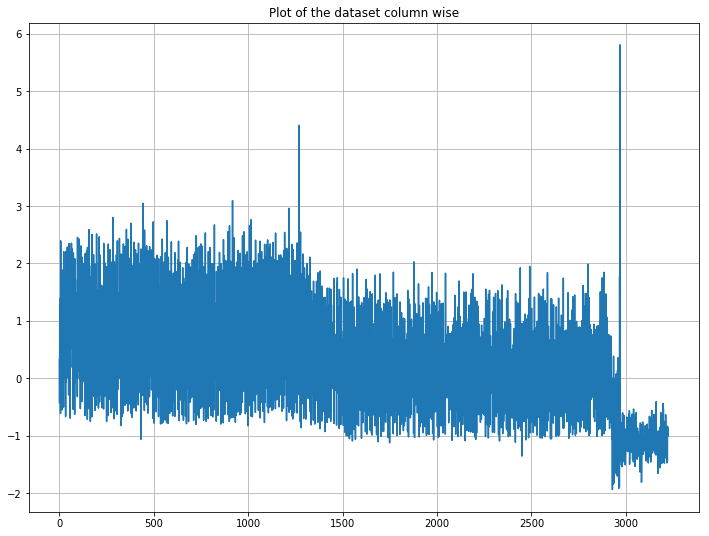

Network dimensions are 8 x 7 


Shape of differenced Training data : (3224, 1)

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 


Saved model : som_trained_model_ec2cpuutilization5f5533_1530212656666 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1530212656666

{"header": {"code": "200", "status": "OK"}, "models": [{"TSFAD_A1": "../../Anomaly_Detection_Models/Machine_Learning_Models\\som_trained_model_ec2cpuutilization5f5533_1530212656666"}]}

Testing mode option : detect and log

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  ec2_cpu_utilization_5f5533
timestamp                                          
1392388320000  TSFAD_A1                    0.325390
1392388620000  T

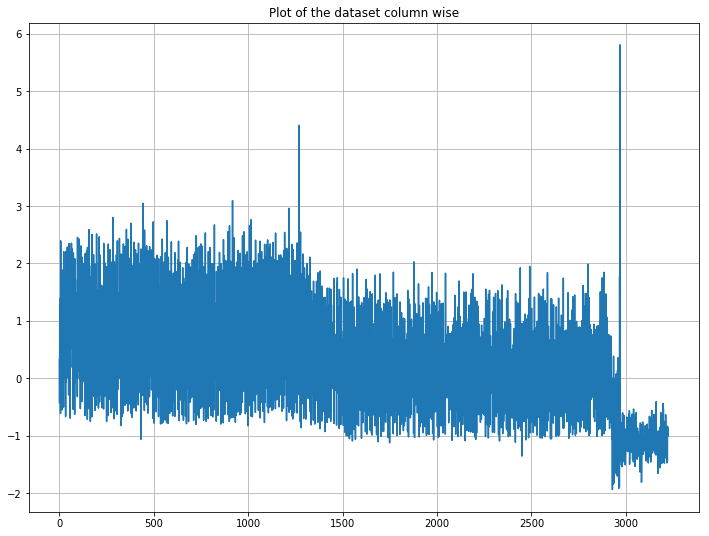

Network dimensions are 8 x 7 


Shape of differenced Training data : (3224, 1)

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 


Saved model : som_trained_model_ec2cpuutilization5f5533_1530212657841 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1530212657841

{"header": {"code": "200", "status": "OK"}, "models": [{"TSFAD_A1": "../../Anomaly_Detection_Models/Machine_Learning_Models\\som_trained_model_ec2cpuutilization5f5533_1530212657841"}]}

Testing mode option : log only

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  ec2_cpu_utilization_5f5533
timestamp                                          
1392388320000  TSFAD_A1                    0.325390
1392388620000  TSFAD_A

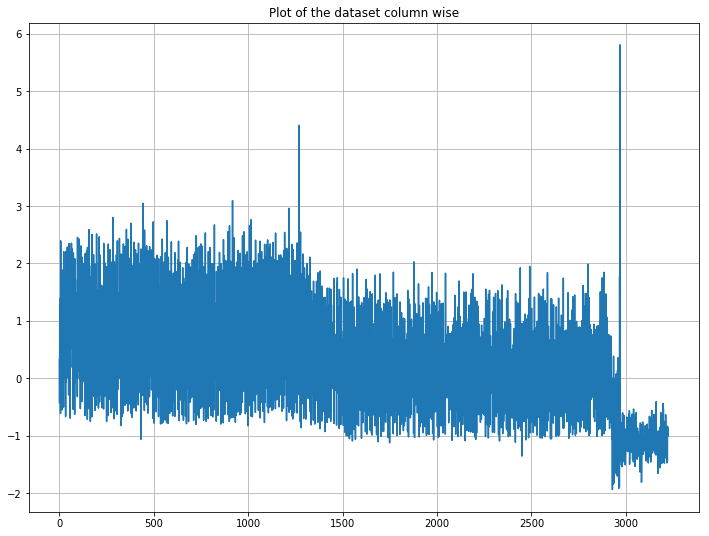

Network dimensions are 8 x 7 


Shape of differenced Training data : (3224, 1)

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 


Saved model : som_trained_model_ec2cpuutilization5f5533_1530212658978 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1530212658978

{"header": {"code": "200", "status": "OK"}, "models": [{"TSFAD_A1": "../../Anomaly_Detection_Models/Machine_Learning_Models\\som_trained_model_ec2cpuutilization5f5533_1530212658978"}]}


In [9]:
json_data = reader_helper.read(reader_kwargs=reader_kwargs())
model_input_args1,training_args1,eval_args1 = get_kwargs()
training_args1['to_plot'] = True

for i in range(3):
    mode = som_wrapper.mode_options[i]
    print("\nTesting mode option : {}\n".format(mode))
    res = som_wrapper.train(**{**model_input_args1,**training_args1},json_data=json_data)
    print(res)

In [13]:
json_data = reader_helper.read(reader_kwargs=reader_kwargs())
model_input_args1,training_args1,eval_args1 = get_kwargs()
training_args1['to_plot'] = True
# print(type(json_data))
mode = som_wrapper.mode_options[0]
print("\nTesting mode option : {}\n".format(mode))
res = som_wrapper.train(**{**model_input_args1,**training_args1},json_data='json_data')
print(res)

http://192.168.2.5:4242/api/query?start=1392388200&end=1393597320&ms=true&m=max:none:ec2_cpu_utilization_5f5533{AssetNo=TSFAD_A1}

Testing mode option : detect only

Data reader initialised 

{"code": "400", "status": "Bad Request", "message": "Expecting value: line 1 column 1 (char 0) - json_data must be proper json object", "data": {"argument": "json_data", "value": "json_data"}}


## Test 1 : 
#### Testing with parameters being empty quotes

In [11]:


json_data = reader_helper.read(reader_kwargs=reader_kwargs())
algo_kwargs1 = algo_kwargs()
for key in keys:
    algo_kwargs1[key]=''
    res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
    print(res)

http://192.168.2.5:4242/api/query?start=1392388200&end=1393597320&ms=true&m=max:none:ec2_cpu_utilization_5f5533{AssetNo=TSFAD_A1}


NameError: name 'algo_kwargs' is not defined

## Test 2 :
#### Testing missing parameters : 

In [ ]:

   
json_data = reader_helper.read(reader_kwargs=reader_kwargs())
algo_kwargs1 = algo_kwargs()
for key in keys:
    del algo_kwargs1[key]
    res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
    print(res)

## Test 3:
#### Testing parameter type mismatch 

In [ ]:
keys

In [ ]:

json_data = reader_helper.read(reader_kwargs=reader_kwargs())
algo_kwargs1 = algo_kwargs()
val = ['2',4.5,'def']
for i,key in enumerate(keys):
    algo_kwargs1[key]=val[i]
    res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
    print(res)

### User Defined Test Case:
#### Testing the fact that probability threshold must be between 0 and 1

In [ ]:
json_data = reader_helper.read(reader_kwargs=reader_kwargs())
algo_kwargs1 = algo_kwargs()
val = [5,4,100]
for i,key in enumerate(keys):
    algo_kwargs1[key]=val[i]
    res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
    print(res)

## Test 4:
#### Testing Algorithm Logic :
* Running the algorithm for different values of probability thresholds
* so expected o/p behaviour expected is as we increase the probability threshold the no of anomaly detected reduces and reaches zero when set to $1.0$
* Default threshold is $0.5$

In [ ]:


reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs=reader_kwargs1)
algo_kwargs1 = algo_kwargs()

pthreses = [0.5,0.01,0.99]

for i,pthres in enumerate(pthreses):
    algo_kwargs1['thres_prob']=pthres
    res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
    print(res)

#### Observe the effect of expected_run_length on the algorithm

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs=reader_kwargs1)
algo_kwargs1 = algo_kwargs()
algo_kwargs1['thres_prob'] = 0.5
mean_run_lens = [0,100,10000]
for i,mean_run_len in enumerate(mean_run_lens):
    print('\n Anomaly detection for expected run length  = {}\n'.format(mean_run_len))
    algo_kwargs1['expected_run_length']=mean_run_len
    res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
    print(res)

##### Results:
* As we observed that when expected run length given zero. the algo stops and throws an zero division error as expected/
* Then as we increase it from zero, we observed that interval between changepoints increased

## Test 5:
#### Testing Algorithm tuning :
* Trying to change the parameters of algorithm and observe the results obtained
* Here we try to tune the algo to run faster and as we observe that on increasing expected run length, the sensitivity of detecting changepoints decreases which we saw above case too.

In [ ]:
%%timeit -n 1 -r 1

algo_kwargs1 = algo_kwargs()

    
reader_kwargs1 = csv_helper.get_csv_kwargs(infile='../../dataset/bearings_1.csv',
                                           filename='bearings_1.csv',n_rows=5000,has_time=False)
json_data = reader_helper.read(reader_kwargs=reader_kwargs1)

res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
print(res)

## Test 6:
#### Testing Asset Timeline Logging :

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
print(res)

!['Asset timeline logging 1'](./atl_test2_bayes.png)
!['Asset timeline logging 2](./atl_test3_bayes.png)

## Test 7:
#### Testing the response from program to follow agreed upon template :

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
print(res)

## Test 8:
#### Testing No Data exception :
* To get empty dataframe we set from and to timestamp to be not in range of the timestamps in dataset analysed

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
reader_kwargs1['from_timestamp'] = int(2**60)
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
print(res)

## Test 9:
#### Testing Database connectivity  exception :
* To test this we edit the db properties and run the algo

In [ ]:
writer_configs.table_name = 'f'

In [ ]:
db_properties.db_connection

### We change the db name and we expect a database error as shown below

In [ ]:
db_properties.db_connection['dbname'] = 'eg'

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
algo_kwargs1['to_plot'] = False
res = bayeschangept.main(**algo_kwargs1,json_data=json_data,mode=bayeschangept.mode_options[2])
print(res)

### Now we try to change the password of db properties and observe the exception handled

In [ ]:
db_properties.db_connection['password']='fef'

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
algo_kwargs1['to_plot'] = False
res = bayeschangept.main(**algo_kwargs1,json_data=json_data,mode=bayeschangept.mode_options[2])
print(res)

In [ ]:
%%writefile_run db_properties.py

db_connection = {'dbname': 'Cerebra',
 'host': '127.0.0.1',
 'password': 'givemeachance',
 'port': '5432',
 'user': 'postgres'}

### Now we change the table name in which we are writing, and we observe that relation doesn't exist as seen below

In [ ]:
writer_configs.table_name = 'ffee'

In [ ]:

reader_kwargs1 = csv_helper.get_csv_kwargs()
# reader_kwargs1['from_timestamp'] = int(2**60)
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
algo_kwargs1['to_plot'] = False
res = bayeschangept.main(**algo_kwargs1,json_data=json_data,mode=bayeschangept.mode_options[2])
print(res)

In [ ]:
writer_configs.table_name = 'public.log_asset_timeline'

## Test 10:
#### Testing random exceptions :

In [ ]:
reader_kwargs1 = csv_helper.get_csv_kwargs()
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
algo_kwargs1['to_plot'] = False
res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
print(res)

## Test 11:
#### Testing High Performance :

In [ ]:
%%timeit -n 1 -r 1
reader_kwargs1 = csv_helper.get_csv_kwargs(infile='../../dataset/bearings_1.csv',filename='bearings_1.csv',n_rows=15000,has_time=False)
json_data = reader_helper.read(reader_kwargs1)
algo_kwargs1 = algo_kwargs()
algo_kwargs1['to_plot']=False
res = bayeschangept.main(**algo_kwargs1,json_data=json_data)
print(res)

####  We observe that for running oddly $15000$ datapoints for $1$ metric name it takes around $58.7$ seconds to run.
* I believe that reason for this timing is the algo computes the matrix of order of $NxN$ where $N$ is the size of dataset.
* So it takes lot of time to compute that

# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets